# Compare Twitter and Reddit Populations

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [19]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

In [5]:
top_n_domains = 100
bootstrap_count = 5000

In [6]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [7]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [8]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [9]:

twitter_top_tlds_rand = get_top_tlds(twitter_links_df_rand, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_poli = get_top_tlds(twitter_links_df_poli, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_ira = get_top_tlds(twitter_links_df_ira, user_id_field="user_id", top_n=top_n_domains)

twitter_merged_tlds = set(twitter_top_tlds_rand + twitter_top_tlds_poli + twitter_top_tlds_ira)
print("Merged Top TLDs:", len(twitter_merged_tlds))


Merged Top TLDs: 152


In [10]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [11]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [12]:

reddit_top_tlds_rand = get_top_tlds(reddit_links_df_rand, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_poli = get_top_tlds(reddit_links_df_poli, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_ira = get_top_tlds(reddit_links_df_ira, user_id_field="user_name", top_n=top_n_domains)

reddit_merged_tlds = set(reddit_top_tlds_rand + reddit_top_tlds_poli + reddit_top_tlds_ira)
print("Merged Top TLDs:", len(reddit_merged_tlds))

Merged Top TLDs: 180


In [103]:
cross_platform_tlds = twitter_merged_tlds.union(reddit_merged_tlds)

# Pop off these ultra-common TLDs. 
#. The motivation here is that twitter.com is injected 
#.  when a Twitter user retweets, and sharing within 
#.  Reddit through crossposting increases its prevalence.
#.  These phenomena will make activity across populations
#.  appear artificially more similar than they ought to be.
cross_platform_tlds.remove("twitter.com")
cross_platform_tlds.remove("reddit.com")

print("Cross-Platform Top TLDs:", len(cross_platform_tlds))

Cross-Platform Top TLDs: 237


In [104]:
print("TLDs in Reddit but not Twitter:")
for tld in sorted(reddit_merged_tlds.difference(twitter_merged_tlds)):
    print("\t", tld)

TLDs in Reddit but not Twitter:
	 500px.org
	 9cache.com
	 9gag.com
	 aljazeera.com
	 ap.org
	 archive.is
	 archive.org
	 arstechnica.com
	 baltimoresun.com
	 bandcamp.com
	 blackmattersus.com
	 butthis.com
	 cbc.ca
	 cbssports.com
	 chicagotribune.com
	 colorlines.com
	 conservativetribune.com
	 cosmopolitan.com
	 countercurrentnews.com
	 craigslist.org
	 csmonitor.com
	 dailymotion.com
	 deviantart.com
	 deviantart.net
	 donotshoot.us
	 ebay.com
	 esquire.com
	 euronews.com
	 fbcdn.net
	 fivethirtyeight.com
	 flickr.com
	 fortune.com
	 gfycat.com
	 gifsound.com
	 giphy.com
	 github.com
	 gizmodo.com
	 globalnews.ca
	 googleusercontent.com
	 gyazo.com
	 heatst.com
	 hollywoodreporter.com
	 ibtimes.com
	 ign.com
	 imdb.com
	 imgflip.com
	 kickstarter.com
	 liveleak.com
	 magaimg.net
	 marketwatch.com
	 mcclatchydc.com
	 mentalfloss.com
	 mirror.co.uk
	 nbcnewyork.com
	 news.com.au
	 nocookie.net
	 photographyisnotacrime.com
	 pinimg.com
	 plays.tv
	 pornhub.com
	 postimg.org
	 puu.sh
	

In [105]:
print("TLDs in Twitter but not Reddit:")
for tld in sorted(twitter_merged_tlds.difference(reddit_merged_tlds)):
    print("\t", tld)

TLDs in Twitter but not Reddit:
	 abcnews.go.com
	 americanthinker.com
	 apple.com
	 apple.news
	 atmlb.com
	 bb4sp.com
	 birdops.com
	 bit.ly
	 bizjournals.com
	 blbrd.cm
	 bostonglobe.com
	 cbsn.ws
	 commun.it
	 complex.com
	 crowdfireapp.com
	 dld.bz
	 drudge.tw
	 economist.com
	 eventbrite.com
	 fastcompany.com
	 feedsportal.com
	 freebeacon.com
	 fw.to
	 gofund.me
	 goo.gl
	 gu.com
	 http:///__connectionpool_error__
	 huffpost.com
	 hugedomains.com
	 inc.com
	 ind.pn
	 investors.com
	 itun.es
	 linkedin.com
	 lnk.to
	 mash.to
	 ow.ly
	 paper.li
	 periscope.tv
	 pinterest.com
	 po.st
	 pscp.tv
	 read.bi
	 reportsecret.com
	 shr.lc
	 si.com
	 slate.me
	 smarturl.it
	 snpy.tv
	 theblaze.com
	 theonion.com
	 twitchy.com
	 twittascope.com
	 usa.gov
	 variety.com
	 wh.gov
	 whitehouse.gov
	 wired.com
	 xxlmag.com


In [106]:
domains = sorted(cross_platform_tlds)

In [107]:
twitter_user_tld_links_df_rand = links_df_to_shares(twitter_links_df_rand, domains, "user_id")
twitter_user_tld_links_df_poli = links_df_to_shares(twitter_links_df_poli, domains, "user_id")
twitter_user_tld_links_df_ira = links_df_to_shares(twitter_links_df_ira, domains, "user_id")


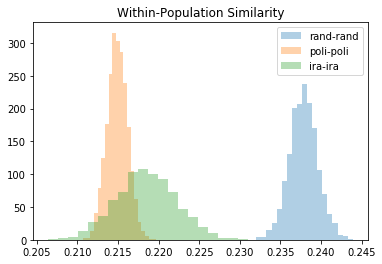

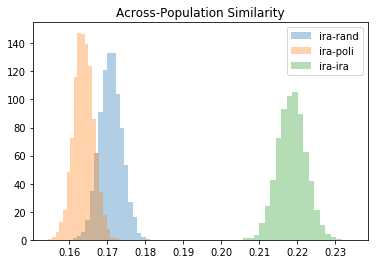

In [108]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
twitter_user_links_mat_rand = sklearn.preprocessing.normalize(twitter_user_tld_links_df_rand[domains], norm="l2", axis=1)
twitter_user_links_mat_poli = sklearn.preprocessing.normalize(twitter_user_tld_links_df_poli[domains], norm="l2", axis=1)
twitter_user_links_mat_ira = sklearn.preprocessing.normalize(twitter_user_tld_links_df_ira[domains], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_poli)
t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_rand)
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_rand_poli_sim_avg = (np.sum(t2t_rand_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(t2t_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(t2t_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(t2t_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [109]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(t2t_rand_rand_sim_avg_bootstrap, t2t_poli_poli_sim_avg_bootstrap, t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(t2t_poli_poli_sim_avg_bootstrap, t2t_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(t2t_ira_rand_sim_avg_bootstrap, t2t_ira_poli_sim_avg_bootstrap, axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 124632.74044993306
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 -65.61672653874169
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 127.40366185176177


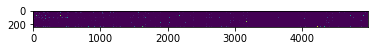

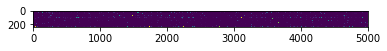

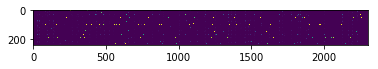

In [110]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

In [111]:
for label, mat in [
    ("Random", twitter_user_links_mat_rand), 
    ("Political", twitter_user_links_mat_poli), 
    ("IRA", twitter_user_links_mat_ira)]:
    print(label)
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

Random
	 vine.co 0.33697106369754426
	 instagram.com 0.2356967215027085
	 youtube.com 0.21778404264470602
	 facebook.com 0.0931531423583054
	 twimg.com 0.05296008092590901
	 soundcloud.com 0.03807260785465649
	 nytimes.com 0.03634575927510595
	 washingtonpost.com 0.022378761581992108
	 cnn.com 0.02196857754613365
	 espn.com 0.021648774782558763
Political
	 youtube.com 0.27356062200264714
	 instagram.com 0.23686171815151916
	 facebook.com 0.15945960283171925
	 nytimes.com 0.11899194544684079
	 washingtonpost.com 0.08582407121705707
	 cnn.com 0.06341772022012632
	 foxnews.com 0.060457891484216465
	 thehill.com 0.058412855556137705
	 vine.co 0.048571799980508965
	 huffingtonpost.com 0.04379794626217771
IRA
	 youtube.com 0.411743737354742
	 vine.co 0.1444492570860999
	 instagram.com 0.09621014041889298
	 hugedomains.com 0.07744985089009444
	 vimeo.com 0.04711310309836829
	 cnn.com 0.03917886098144073
	 facebook.com 0.03906062043005691
	 telegraph.co.uk 0.03812046487073073
	 rt.com 0.031357

In [112]:
reddit_user_tld_links_df_rand = links_df_to_shares(reddit_links_df_rand, domains, "user_name")
reddit_user_tld_links_df_poli = links_df_to_shares(reddit_links_df_poli, domains, "user_name")
reddit_user_tld_links_df_ira = links_df_to_shares(reddit_links_df_ira, domains, "user_name")


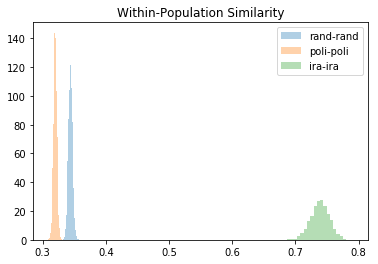

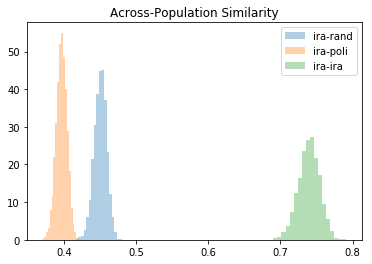

In [113]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
reddit_user_links_mat_rand = sklearn.preprocessing.normalize(reddit_user_tld_links_df_rand[domains], norm="l2", axis=1)
reddit_user_links_mat_poli = sklearn.preprocessing.normalize(reddit_user_tld_links_df_poli[domains], norm="l2", axis=1)
reddit_user_links_mat_ira = sklearn.preprocessing.normalize(reddit_user_tld_links_df_ira[domains], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_poli)
r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_rand)
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_rand_poli_sim_avg = (np.sum(r2r_rand_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(r2r_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(r2r_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(r2r_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [114]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2r_rand_rand_sim_avg_bootstrap, r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_ira_rand_sim_avg_bootstrap, r2r_ira_poli_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 3480435.72424317
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 -1966.5203061706666
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 331.3561302603994


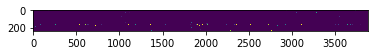

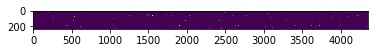

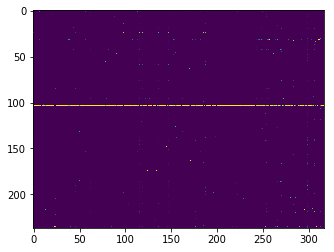

In [115]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

In [116]:
for label, mat in [
    ("Random", reddit_user_links_mat_rand), 
    ("Political", reddit_user_links_mat_poli), 
    ("IRA", reddit_user_links_mat_ira)]:
    print(label)
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

Random
	 imgur.com 0.5158175950306378
	 youtube.com 0.2652829354385842
	 reddituploads.com 0.07611382620798912
	 gfycat.com 0.01997621556544836
	 soundcloud.com 0.013306197733558036
	 google.com 0.012657892724028782
	 twitch.tv 0.01235674700288192
	 facebook.com 0.010533296094564987
	 tumblr.com 0.009946900277867918
	 wikipedia.org 0.009129076193210963
Political
	 imgur.com 0.44963453138104076
	 youtube.com 0.3264878225948672
	 reddituploads.com 0.05133448389604449
	 sli.mg 0.04399346901255201
	 washingtonpost.com 0.034688732188910505
	 nytimes.com 0.0303525281727795
	 cnn.com 0.024502744597338436
	 archive.is 0.017169351335602347
	 wikipedia.org 0.01606184547614612
	 facebook.com 0.015909345194382172
IRA
	 imgur.com 0.8577030744265731
	 butthis.com 0.036638566991966715
	 youtube.com 0.028031351706611436
	 blackmattersus.com 0.023716361713390432
	 cnn.com 0.008351572354369672
	 vine.co 0.008292420710759859
	 huffingtonpost.com 0.007662048890630857
	 donotshoot.us 0.006677127685295111
	

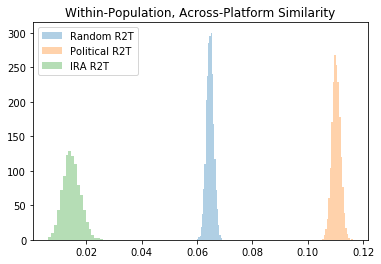

In [117]:
# Calculate pairwise similarity among users across platforms
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, twitter_user_links_mat_rand)
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, twitter_user_links_mat_poli)
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [118]:
# Test whether the across-platform similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2t_rand_sim_avg_bootstrap, r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_rand_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Random and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 2539653.6911109975
p-value for Welch's t-Test between Random and IRA: 0.0 1055.594934390333
p-value for Welch's t-Test between Poli and IRA: 0.0 1968.6015436546381
